# Tutorials for case studies

In [20]:
library(CellChat)
library(celltalker)
library(ggplot2)                  
library(patchwork)
library(ggalluvial)
library(igraph)
library(dplyr)
library(tidyr)
library(Seurat)
library(abind)
library(reshape2)
library(CombinePValue)
library(stringr)
library(purrr)
library(remotes)
library(jsonlite)
library(RColorBrewer)
options(stringsAsFactors = FALSE)

## Perform integrated inference for cell-cell communication networks
### The complete R script can also be run within the infer.r file.

In [21]:
invisible({
    
    genecount_path = "example/Adult-Heart1_filtered.txt"
    genemeta_path = "example/Adult-Heart1_filtered_anno.csv"

    genecount <- as.matrix(read.table(genecount_path, header = TRUE, sep = ','))
    genemeta <- read.csv(genemeta_path, row.names=NULL)

    rownames(genemeta) <- genemeta$Cell_id
    genemeta <- genemeta[, !colnames(genemeta) %in% "Cell_id"] ## the rownames of genemeta must be cell_id (same to the colnames of genecount)
    ser.obj <- CreateSeuratObject(genecount, meta.data=genemeta)
    ser.obj <- ser.obj[, ser.obj@meta.data$Celltype != "NA"] ## only recognized celltypes considered


    expressionMatrix <- GetAssayData(ser.obj, assay = "RNA")
    geneExpression <- rowMeans(expressionMatrix)
    sortedGenes <- names(geneExpression)[order(geneExpression, decreasing = TRUE)]
    topGenes <- sortedGenes[1:5000]
    ser.obj <- subset(ser.obj, features = topGenes)
    ser.obj

    ### Read in L-R pair database
    pairs <- readRDS('example/collected_pairs_new.rds')

    ### Read in project name
    project = 'test'
    
    start_time <- Sys.time()

    ser.obj <- NormalizeData(ser.obj)
    ser.obj <- FindVariableFeatures(ser.obj)
    ser.obj <- ScaleData(ser.obj)
    ser.obj <- RunPCA(ser.obj)
    ser.obj <- RunUMAP(ser.obj,reduction="pca",dims=1:15)
    ser.obj <- FindNeighbors(ser.obj,reduction="pca",dims=1:15)
    ser.obj <- FindClusters(ser.obj,resolution=0.5)
    
    ### CellChat

    cellchat<- createCellChat(object =ser.obj, group.by = "Celltype")
    cellchat@DB <- CellChatDB.human
    cellchat <- subsetData(cellchat)
    cellchat <- identifyOverExpressedGenes(cellchat)
    cellchat <- identifyOverExpressedInteractions(cellchat)
    cellchat <- computeCommunProb(cellchat, raw.use = TRUE)
    cellchat <- filterCommunication(cellchat, min.cells = 10)
    cellchat <- computeCommunProbPathway(cellchat)
    cellchat <- aggregateNet(cellchat) ### rds
    end_time <- Sys.time() - start_time
})

print(end_time)

Centering and scaling data matrix

PC_ 1 
Positive:  ADIRF, TAGLN, ACTA2, MYL9, DSTN, TPM2, MGP, MT2A, DCN, RGS16 
	   TIMP3, CLU, NDUFA4L2, MYL6, APOD, PLA2G2A, CSRP2, RGS5, PPP1R14A, IFITM1 
	   RERGL, MT1E, AQP1, IFI27, CALD1, LUM, HES1, C7, TM4SF1, MYH11 
Negative:  FTL, CTSB, C1QB, TYROBP, CTSS, C1QA, FTH1, CD74, NPC2, FCER1G 
	   C1QC, C5AR1, LYZ, TMSB4X, LIPA, GPR183, RNASE1, CD83, MS4A7, CCL3L3 
	   IER3, PLAUR, MAFB, SOD2, VSIG4, CYBB, CXCL3, ITGB2, CXCL8, CCL3 
PC_ 2 
Positive:  SEPP1, RNASE1, LGMN, F13A1, MRC1, C1QA, LYVE1, FCGR2B, CREG1, FCGBP 
	   LILRB5, STAB1, C1QB, GRN, CTSZ, C1QC, CD163, MAF, GPNMB, MT-ND3 
	   FOLR2, ACP5, PMP22, CTSD, SLCO2B1, MS4A4A, DAB2, MS4A6A, MAN1A1, CCL13 
Negative:  FCN1, IL1B, BCL2A1, G0S2, SRGN, B2M, PLAUR, CD52, FTH1, TMSB4X 
	   SOD2, EREG, CCL20, CARD16, NAMPT, S100A8, S100A9, TMSB10, SERPINA1, LST1 
	   GPR183, APOBEC3A, PLAC8, S100A4, CXCL3, CXCL8, AQP9, IL1RN, OLR1, TIMP1 
PC_ 3 
Positive:  DCN, APOD, MGP, LUM, EFEMP1, C7, C1R, MGST1,

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1308
Number of edges: 52538

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8633
Number of communities: 8
Elapsed time: 0 seconds
[1] "Create a CellChat object from a Seurat object"
The `data` slot in the default assay is used. The default assay is RNA 
The `meta.data` slot in the Seurat object is used as cell meta information 
Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  Dendritic cell Endothelial cell Fibroblast M1 Macrophage M2 Macrophage Macrophage Mast cell Neutrophil Smooth muscle cell T cell Ventricle cardiomyocyte 
triMean is used for calculating the average gene expression per cell group. 
[1] ">>> Run CellChat on sc/snRNA-seq data <<< [2024-07-21 02:41:13.586637]"
[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2024-07-21 02:42:14.997076]"
Time difference of 1.1

In [22]:
 ### CellphoneDB
invisible({
    start_time <- Sys.time()

    anno <- data.frame(Cell = rownames(genemeta),
                       cell_type = genemeta$Celltype)
    write.table(anno, "temp_anno.txt", col.names = TRUE, sep = "\t", row.names = FALSE, quote = FALSE)
    write.table(genecount, "temp_matrix.txt", col.names = TRUE, sep = "\t", row.names = TRUE, quote = FALSE)

    system('cellphonedb method statistical_analysis temp_anno.txt temp_matrix.txt --counts-data=gene_name --project-name=test --iterations=30')

    end_time <- Sys.time() - start_time
})
print(end_time)

Time difference of 2.55185 secs


In [23]:
### Celltalker
invisible({
    start_time <- Sys.time()
    celltalker <- celltalk(input_object=ser.obj, metadata_grouping='Celltype', 
                                 ligand_receptor_pairs=pairs,
                                 number_cells_required=100,
                                  min_expression=100,
                                  max_expression=20000,
                                  scramble_times=30)
    end_time <- Sys.time() - start_time
})
print(end_time)

Time difference of 5.238794 secs


In [24]:
### Combined
invisible({
    start_time <- Sys.time()
    cpdb_means <- read.table('out/test/means.txt', sep='\t',header=TRUE)
    cpdb_pval <- read.table('out/test/pvalues.txt', sep='\t',header=TRUE)
    cpdb_decon <- read.table('out/test/deconvoluted.txt', sep='\t')
    colnames(cpdb_decon) <- cpdb_decon[1,]
    cpdb_decon <- cpdb_decon[-1,]
    celltype_cpdb <- colnames(cpdb_decon)[-c(1:6)]

    ### convert each to a 3D matrix
    num <- dim(cellchat@net$prob)[1]
    num_all <- num*num
    celltype <- colnames(cellchat@net$weight)
    ### cellphonedb
    num_pairs <- nrow(cpdb_means)
    cpdb_means_3d <- array(rep(0, num*num*num_pairs), dim=c(num, num, num_pairs))
    cpdb_pval_3d <- array(rep(1, num*num*num_pairs), dim=c(num, num, num_pairs))
    idx <- rep(0,num)
    for (i in 1:num)
    {
        if (celltype_cpdb[i] %in% celltype) idx[i] <- which(celltype==celltype_cpdb[i])
    }
    for (i in 1:num_pairs)
    {
        for (j in 1:num_all)
        {
            cpdb_means_3d[idx[((j-1)%/%num)+1], idx[((j-1)%%num)+1],i] <- cpdb_means[i,j+11]
            cpdb_pval_3d[idx[((j-1)%/%num)+1], idx[((j-1)%%num)+1],i] <- cpdb_pval[i,j+11]
        }
    }
    cpdb_pairs <- cpdb_means$interacting_pair


    ###celltalker
    num_pairs <- length(table(celltalker$interaction))
    ct_pairs <- names(table(celltalker$interaction))
    ct_ligand <- as.character(map(strsplit(ct_pairs, split = '_'), 1))
    ct_receptor <- as.character(map(strsplit(ct_pairs, split = '_'), 2))
    ct_means_3d <- array(rep(0, num*num*num_pairs), dim=c(num, num, num_pairs))
    ct_pval_3d <- array(rep(1, num*num*num_pairs), dim=c(num, num, num_pairs))
    num_pairs_temp <- celltalker$interaction[1]
    j = 1
    for (i in 1:nrow(celltalker))
    {
        if (celltalker$interaction[i] != num_pairs_temp) {
            j = j+1
            num_pairs_temp = celltalker$interaction[i]
        }
        if (celltalker$cell_type1[i] %in% celltype && celltalker$cell_type2[i] %in% celltype){ 
            idx1 <- which(celltype==celltalker$cell_type1[i])
            idx2 <- which(celltype==celltalker$cell_type2[i])
            ct_means_3d[idx1, idx2, j] <- celltalker$value[i]
            ct_pval_3d[idx1, idx2, j] <- celltalker$p_val[i]
        }
    }

    cc_prob_3d <- cellchat@net$prob
    cc_pval_3d <- cellchat@net$pval

    ## normalization
    ct_means_3d_nml <- (ct_means_3d - min(ct_means_3d)) / (max(ct_means_3d) - min(ct_means_3d))
    cpdb_means_3d_nml <- (cpdb_means_3d - min(cpdb_means_3d)) / (max(cpdb_means_3d) - min(cpdb_means_3d))
    cc_prob_3d_nml <- (cc_prob_3d - min(cc_prob_3d)) / (max(cc_prob_3d) - min(cc_prob_3d))
    cc_pairs <- cellchat@LR$LRsig$interaction_name
    cc_ligand <- cellchat@LR$LRsig$ligand
    cc_receptor <- cellchat@LR$LRsig$receptor
    intersect_1 <- intersect(cc_pairs, ct_pairs)
    intersect_2 <- intersect(cc_pairs, cpdb_means$interacting_pair)
    cpdb_pairs <- cpdb_means$interacting_pair
    cpdb_ligand <- cpdb_means$gene_a
    cpdb_receptor <- cpdb_means$gene_b

    ## integration
    for (i in 1:dim(ct_means_3d)[3])
    {
        if(ct_pairs[i] %in% intersect_1)
        {
            idx <- grep(ct_pairs[i], intersect_1)
            cc_prob_3d_nml[,,idx] <- (cc_prob_3d_nml[,,idx]+ct_means_3d_nml[,,i])/2
            for(m in 1:num)
            {
                for(n in 1:num)
                {
                    cc_pval_3d[m,n,idx] <- selfcontained.test(pvalue=c(cc_pval_3d[m,n,idx],ct_pval_3d[m,n,i]))$'significance level for combining pvalues'
                }
            }
        }
    }

    for (i in 1:dim(cpdb_means_3d)[3])
    {
        if(cpdb_pairs[i] %in% intersect_2)
        {
            idx <- grep(cpdb_pairs[i], intersect_2)
            cc_prob_3d_nml[,,idx] <- (cc_prob_3d_nml[,,idx]+cpdb_means_3d_nml[,,i])/2
            for(m in 1:num)
            {
                for(n in 1:num)
                {
                    cc_pval_3d[m,n,idx] <- selfcontained.test(pvalue=c(cc_pval_3d[m,n,idx],cpdb_pval_3d[m,n,i]))$'significance level for combining pvalues'
                }
            }
        }
    }

    pval_3d <- abind(cc_pval_3d, cpdb_pval_3d[,,!cpdb_pairs %in% intersect_2], ct_pval_3d[,,!ct_pairs %in% intersect_1], along=3)
    means_3d <- abind(cc_prob_3d_nml, cpdb_means_3d_nml[,,!cpdb_pairs %in% intersect_2], ct_means_3d_nml[,,!ct_pairs %in% intersect_1], along=3)
    means_3d <- (means_3d - min(means_3d)) / (max(means_3d) - min(means_3d))

    ## save to mysql csv

    combined_pairs <- c(cc_pairs, cpdb_pairs[!cpdb_pairs %in% intersect_2], ct_pairs[!ct_pairs %in% intersect_1])
    combined_ligand <- c(cc_ligand, cpdb_ligand[!cpdb_pairs %in% intersect_2], ct_ligand[!ct_pairs %in% intersect_1])
    combined_receptor <- c(cc_receptor, cpdb_receptor[!cpdb_pairs %in% intersect_2], ct_receptor[!ct_pairs %in% intersect_1])
    dim_a = dim(pval_3d)[1]
    dim_b = dim(pval_3d)[3]

    id = 1
    df <- matrix(0, ncol = 10, nrow = dim_a * dim_a * dim_b)
    for (i in 1:dim_a){
        for (j in 1:dim_a){
            for (k in 1:dim_b){
                if (pval_3d[i,j,k] <= 0.05)
                {
                    df[id, 1] = id
                    df[id, 2] = 'Combined'
                    df[id, 3] = project
                    df[id, 4] = combined_ligand[k]
                    df[id, 5] = combined_receptor[k]
                    df[id, 6] = combined_pairs[k]
                    df[id, 7] = celltype[i]
                    df[id, 8] = celltype[j]
                    df[id, 9] = means_3d[i,j,k]
                    df[id, 10] = pval_3d[i,j,k]
                    id = id + 1
                }
            
            }
        }
    }
    df <- as.data.frame(df[1:(id-1),])
    colnames(df) <- c('id', 'method', 'project', 'ligand', 'receptor', 'interaction', 'celltype1', 'celltype2', 'score', 'pval')
    file <- file('combined_3d.csv', encoding="UTF-8")    
    write.csv(df, file, quote=F, row.names=FALSE)

    ## to 2d

    means_2d <- means_3d[,,1]
    for (i in 2:dim_b)
    {
        means_2d <- means_2d+means_3d[,,i]
        indicate_pval <- pval_3d[,,i]
        indicate_pval <- apply(indicate_pval,2,function(x) ifelse(x > 0.05,0,x))
        indicate_pval <- apply(indicate_pval,2,function(x) ifelse(x <= 0.05,1,x))  
        means_2d <- means_2d*indicate_pval
    }

    rownames(means_2d) <- celltype
    colnames(means_2d) <- celltype

    melt_weight =  melt(as.matrix(means_2d),na.rm=T)
    write.csv(melt_weight, file='combined_2d.csv', quote=F)
                            
    end_time <- Sys.time() - start_time
})
print(end_time)


Time difference of 1.112665 secs


### Applications 2: collectNET reveals the topological characteristics of communication networks.

In [25]:
melt_weight = melt_weight[melt_weight[, 3] > 1.25, ]
# The default value for the intercellular interaction threshold is 1.25, but it can be adjusted.

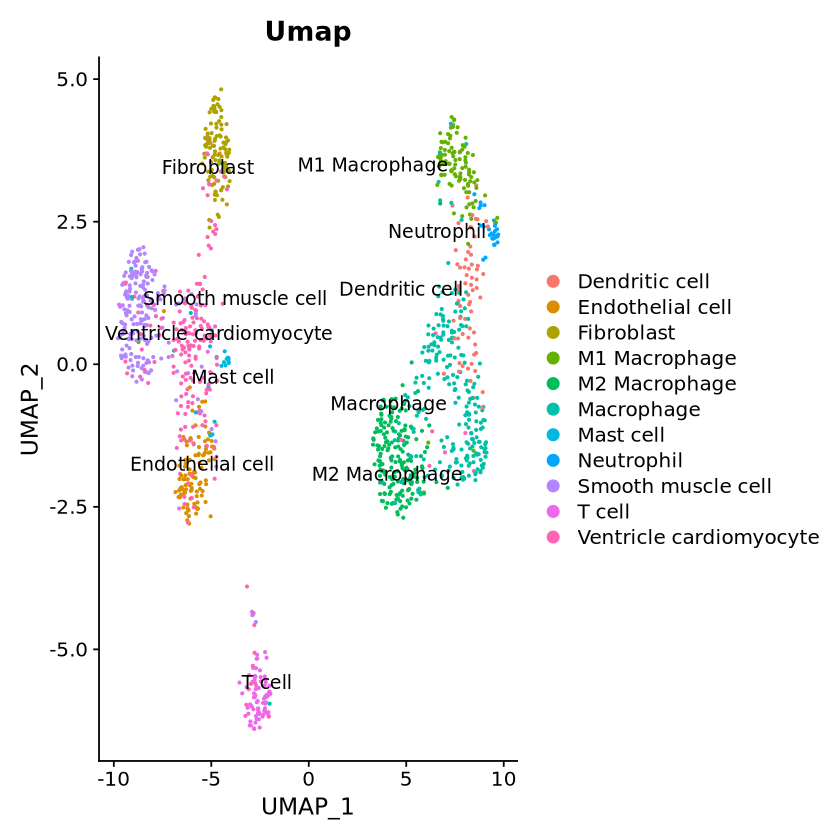

In [26]:
DimPlot(ser.obj, reduction = "umap",repel = T, label = TRUE, group.by = "Celltype", pt.size=0.5) + labs(title = "Umap")

In [27]:
g <- graph_from_data_frame(melt_weight, directed=TRUE)
g.sym <- as.undirected(g, mode= "collapse",

                         edge.attr.comb=list(weight="sum", "ignore"))

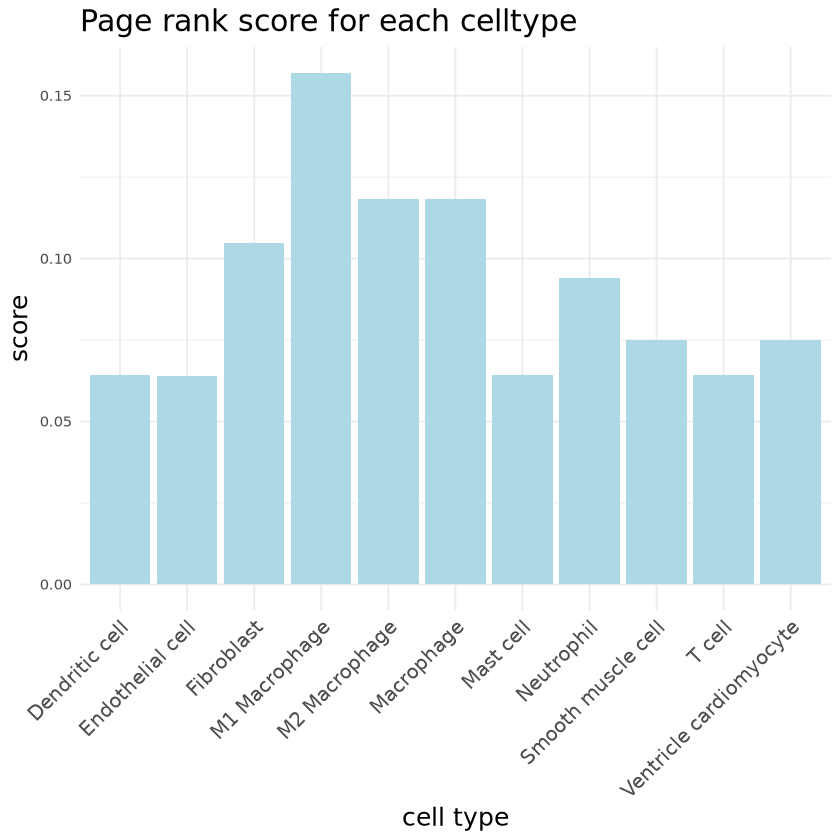

In [28]:
df <- data.frame(page_rank(g)$vector)
df$celltype <- rownames(df)
df$value <- df$page_rank.g..vector

ggplot(df, aes(x = celltype, y = value)) +
  geom_bar(stat = "identity", fill = "lightblue") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 12)) + 
  labs(x = "cell type", y = "score", title = "Page rank score for each celltype") + 
  theme(axis.title = element_text(size = 15), plot.title = element_text(size = 18))


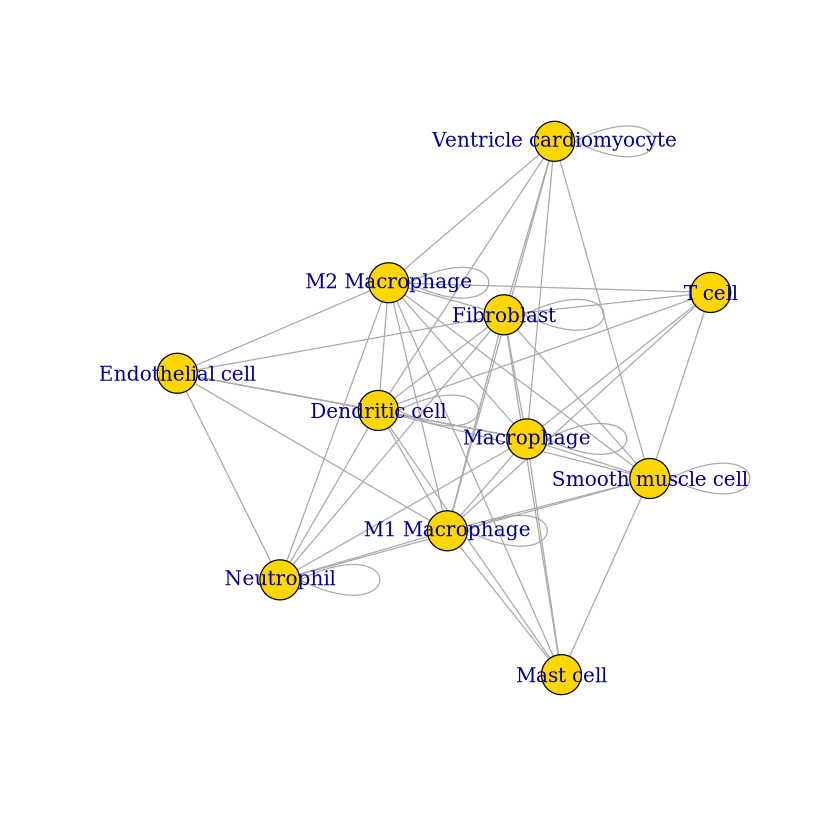

In [29]:
vcol <- rep("grey80", vcount(g.sym))

vcol[unlist(largest_cliques(g.sym))] <- "gold"

plot(as.undirected(g.sym), vertex.label=V(g.sym)$name, vertex.color=vcol)

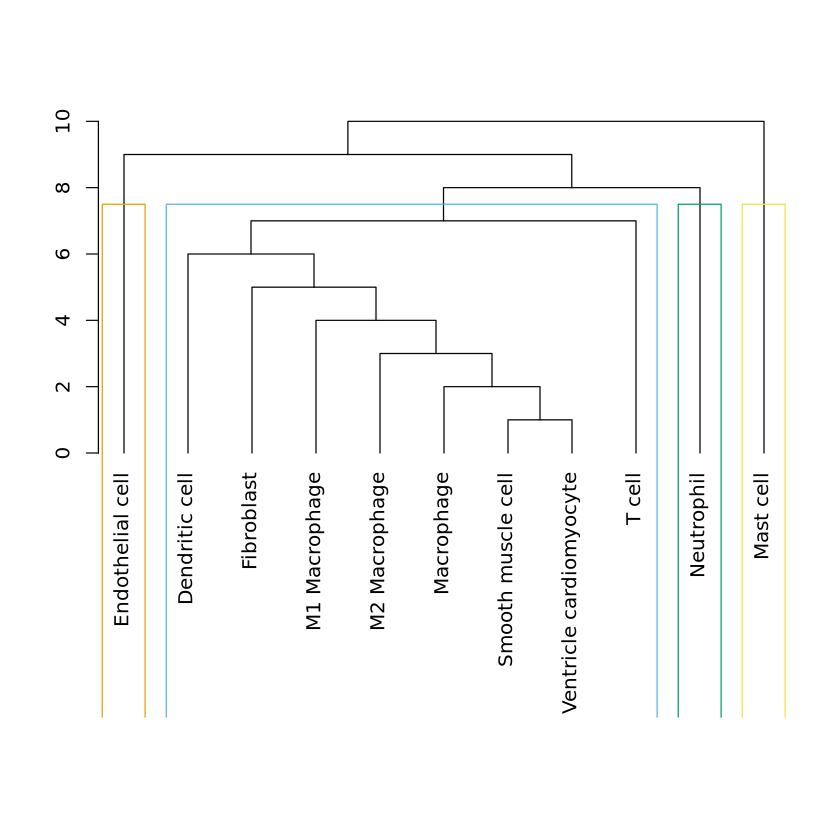

In [32]:
ceb <- cluster_edge_betweenness(g) 

dendPlot(ceb, mode="hclust")

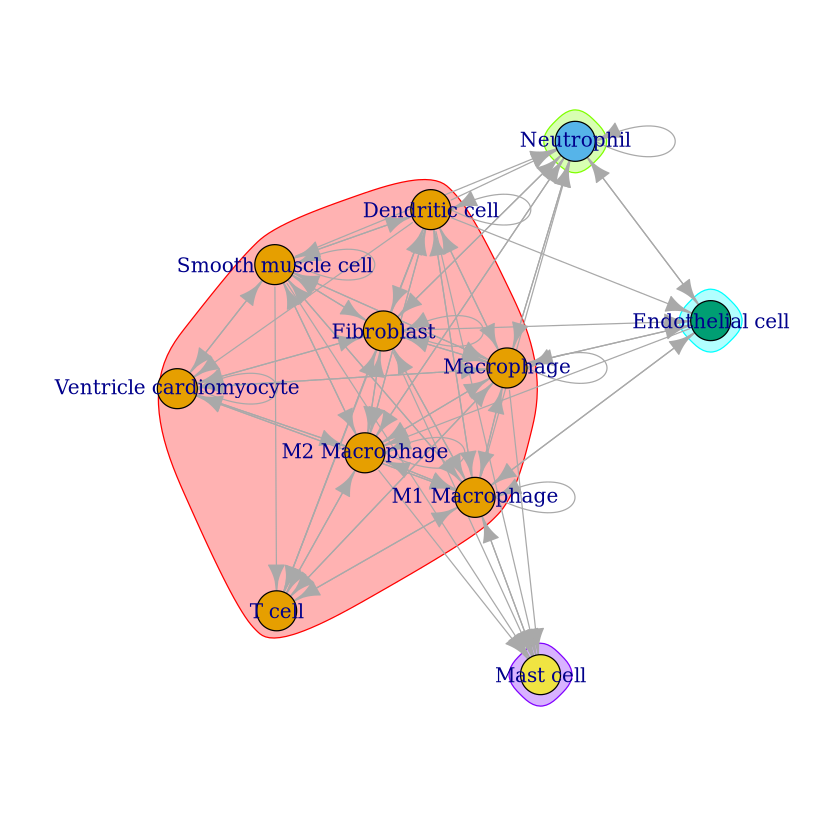

In [33]:
plot(ceb, g, edge.color = "darkgrey") 

### Applications 3: collectNET corroborates the efficacy of the inference methodology through statistical methods.

In [34]:
compress_to_2d <- function(matrix) {
  compressed_matrix <- apply(matrix, c(1, 2), function(x) sum(x)/length(x))
  return(compressed_matrix)
}

cpdb_means_2d <- compress_to_2d(cpdb_means_3d_nml)
ct_means_2d <- compress_to_2d(ct_means_3d_nml)
cc_means_2d <- compress_to_2d(cc_prob_3d_nml)

In [35]:
cor.test(means_2d, ct_means_2d, method='pearson')$estimate
cor.test(means_2d, cpdb_means_2d, method='pearson')$estimate
cor.test(means_2d, cc_means_2d, method='pearson')$estimate

cor 
0.9897875

cor 
0.468598

cor 
0.4802699

In [36]:
cor.test(means_2d, ct_means_2d, method="pearson")$p.value
cor.test(means_2d, cc_means_2d, method="pearson")$p.value
cor.test(means_2d, cc_means_2d, method="pearson")$p.value

[1] 1.549018e-102

[1] 2.480749e-08

[1] 2.480749e-08